In [1]:
# 1. Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
from tqdm import tqdm
import timm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# 2. Path dataset
train_path = "/kaggle/input/fracturedataset/Bone_Fracture_Binary_Classification/train"
val_path = "/kaggle/input/fracturedataset/Bone_Fracture_Binary_Classification/val"
test_path = "/kaggle/input/fracturedataset/Bone_Fracture_Binary_Classification/test"

In [3]:
# 3. Get image paths
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

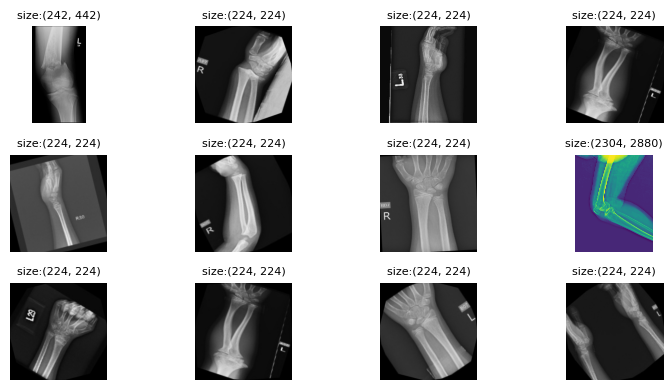

In [4]:
# 4. Display dataset

def display_dataset(path, num_images=12):
    random.seed(322)
    images_paths = get_image_paths(path)
    random_images = random.sample(images_paths, num_images)
    fig, axes = plt.subplots(3, 4, figsize=(8, 4))

    for i, ax in enumerate(axes.flat):
        image_path = random_images[i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"size:{image.size}", fontsize=8)

    plt.tight_layout()
    plt.show()

display_dataset(val_path)

In [5]:
# 5. Handle transparency
class HandleTransparency(object):
    def __call__(self, img):
        if img.mode in ['RGBA', 'LA']:
            img = img.convert('L')
        elif img.mode == 'P':
            img = img.convert('RGBA').convert('L')
        else:
            img = img.convert('L')
        return img


In [6]:
# 6. Transforms
train_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [7]:
# 7. Load datasets
train_ds = ImageFolder(train_path, transform=train_transforms)
val_ds = ImageFolder(val_path, transform=val_transforms)

train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=False)

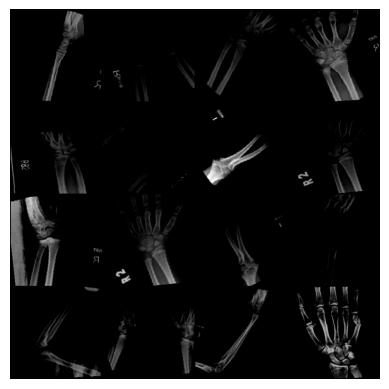

In [8]:
# 8. Show batch images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_dataloader)
images, _ = next(dataiter)
imshow(vutils.make_grid(images[:16], nrow=4))

In [9]:
# 9. Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
# 10. Load ViT model
model = timm.create_model('vit_base_patch16_224.augreg_in21k_ft_in1k', pretrained=True)
model.patch_embed.proj = nn.Conv2d(
    in_channels=1,
    out_channels=model.patch_embed.proj.out_channels,
    kernel_size=model.patch_embed.proj.kernel_size,
    stride=model.patch_embed.proj.stride,
    padding=model.patch_embed.proj.padding,
    bias=False
)
in_features = model.head.in_features
model.head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 2)
)
model = model.to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [11]:
# 11. Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [12]:
# 12. Training/validation loop
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    acc = 100 * correct / len(dataloader.dataset)
    return total_loss / len(dataloader), acc, all_labels, all_preds

def train(model, train_dl, val_dl, criterion, optimizer, scheduler, epochs=20):
    train_losses, val_losses, accs = [], [], []
    all_labels, all_preds = [], []
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_dl, criterion, optimizer)
        val_loss, acc, labels, preds = validate(model, val_dl, criterion)
        scheduler.step()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accs.append(acc)
        all_labels.extend(labels)
        all_preds.extend(preds)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Acc {acc:.2f}%")
    return train_losses, val_losses, accs, all_labels, all_preds


In [13]:
train_losses, val_losses, accs, all_labels, all_preds = train(
    model, train_dataloader, val_dataloader, criterion, optimizer, scheduler
)

 31%|███       | 4/13 [00:05<00:11,  1.30s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 13/13 [00:16<00:00,  1.27s/it]


Epoch 1: Train Loss 0.9493 | Val Loss 0.7691 | Acc 40.65%


100%|██████████| 13/13 [00:11<00:00,  1.15it/s]


Epoch 2: Train Loss 0.6872 | Val Loss 0.5749 | Acc 70.45%


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 3: Train Loss 0.5136 | Val Loss 0.4237 | Acc 79.73%


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


Epoch 4: Train Loss 0.3661 | Val Loss 0.3195 | Acc 86.85%


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 5: Train Loss 0.2046 | Val Loss 0.2157 | Acc 92.04%


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


Epoch 6: Train Loss 0.1345 | Val Loss 0.2041 | Acc 92.28%


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 7: Train Loss 0.1026 | Val Loss 0.1973 | Acc 93.49%


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 8: Train Loss 0.0765 | Val Loss 0.1514 | Acc 93.85%


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


Epoch 9: Train Loss 0.0462 | Val Loss 0.1398 | Acc 94.69%


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 10: Train Loss 0.0401 | Val Loss 0.1428 | Acc 93.97%


100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


Epoch 11: Train Loss 0.0307 | Val Loss 0.1156 | Acc 96.14%


100%|██████████| 13/13 [00:11<00:00,  1.15it/s]


Epoch 12: Train Loss 0.0334 | Val Loss 0.0863 | Acc 96.62%


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 13: Train Loss 0.0219 | Val Loss 0.1041 | Acc 96.14%


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 14: Train Loss 0.0167 | Val Loss 0.0816 | Acc 96.50%


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


Epoch 15: Train Loss 0.0154 | Val Loss 0.0758 | Acc 96.98%


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 16: Train Loss 0.0177 | Val Loss 0.0816 | Acc 96.14%


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 17: Train Loss 0.0131 | Val Loss 0.0765 | Acc 96.50%


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


Epoch 18: Train Loss 0.0126 | Val Loss 0.0641 | Acc 97.10%


100%|██████████| 13/13 [00:11<00:00,  1.14it/s]


Epoch 19: Train Loss 0.0123 | Val Loss 0.0770 | Acc 96.98%


100%|██████████| 13/13 [00:11<00:00,  1.13it/s]

Epoch 20: Train Loss 0.0099 | Val Loss 0.0724 | Acc 96.86%


In [14]:
# 13. Save model
os.makedirs("FracturedDataVIT", exist_ok=True)
torch.save(model.state_dict(), "FracturedDataVIT/model.pt")

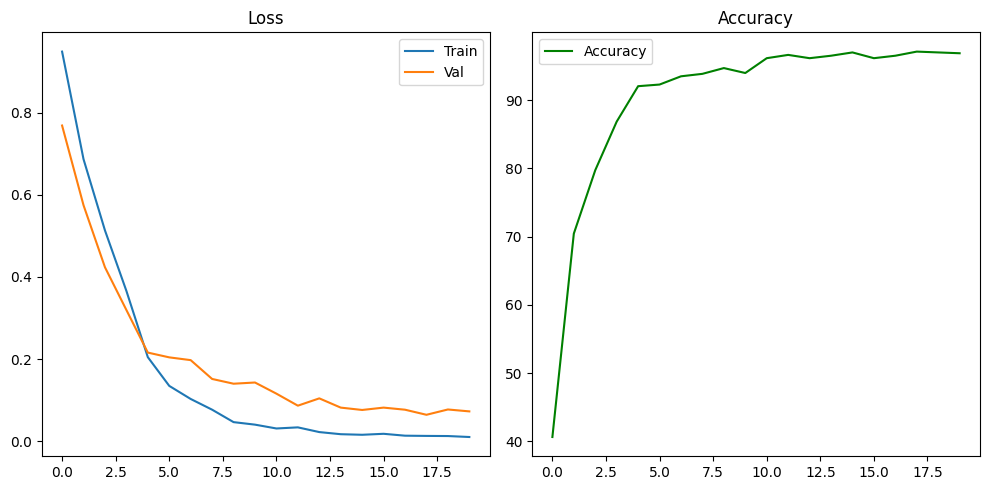

In [15]:
# 14. Plot learning curves
def plot_curves(train_losses, val_losses, accs):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.title("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accs, label='Accuracy', color='green')
    plt.title("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curves(train_losses, val_losses, accs)

In [16]:
def predict_image(image_path, model, transforms, device):
    image = Image.open(image_path)
    image = transforms(image).unsqueeze(0)  # Thêm batch dimension

    image = image.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

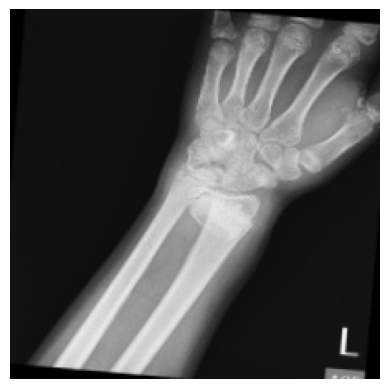

predict: 0 (fractured)
true label: fractured


In [17]:
image_path = random.choice(get_image_paths(test_path))
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()

predicted_class = predict_image(image_path, model, val_transforms, device)
true_class = image_path.split('/')[-2]

print(f"predict: {predicted_class} ({train_ds.classes[predicted_class]})")
print(f"true label: {true_class}")

In [18]:
test_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Thêm normalize giống train
])

test_ds = ImageFolder(test_path, transform=test_transforms)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=False)


In [19]:
def measure_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

print(f"Validation Accuracy: {measure_accuracy(model, val_dataloader):.2f}%")
print(f"Test Accuracy: {measure_accuracy(model, test_dataloader):.2f}%")


Validation Accuracy: 96.86%
Test Accuracy: 96.25%


In [20]:
def get_predictions(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred


In [21]:
y_true, y_pred = get_predictions(model, test_dataloader)

# Tên lớp lấy từ test dataset
class_names = test_ds.classes

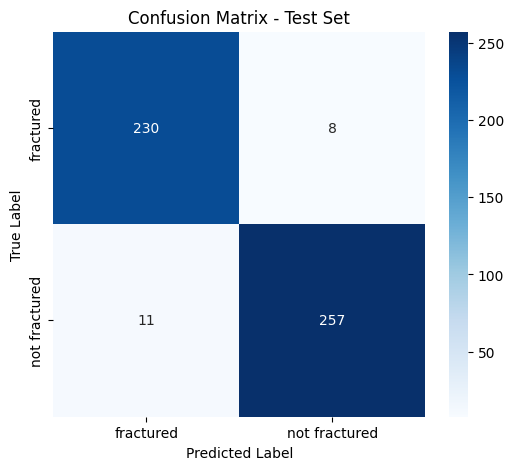

In [22]:
# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()


In [23]:
# In classification report chi tiết theo từng lớp
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# In tổng hợp các chỉ số chung (macro)
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("=== Overall Metrics (Macro Average) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


=== Classification Report ===
               precision    recall  f1-score   support

    fractured       0.95      0.97      0.96       238
not fractured       0.97      0.96      0.96       268

     accuracy                           0.96       506
    macro avg       0.96      0.96      0.96       506
 weighted avg       0.96      0.96      0.96       506

=== Overall Metrics (Macro Average) ===
Accuracy : 0.9625
Precision: 0.9621
Recall   : 0.9627
F1 Score : 0.9623
